In [1]:
import torch
import numpy as np
import datasets
import os
import random
import sqlite3
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from pprint import pprint
from tqdm import tqdm
from multiprocessing import Pool
from itertools import chain
from datasets import Dataset
from matplotlib import pyplot as plt

from nbtools.sent_encoders.hf_models import from_hf
from nbtools.utils import (
    files,
    tensor_utils,
    display,
)
cache_dir = f'{files.project_root()}/cache'
data_dir = f'{files.project_root()}/data'
display.note(f'cache_dir set to \'{cache_dir}\'')
display.note(f'data set to \'{data_dir}\'')

datasets.disable_caching()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline


[NOTE] cache_dir set to '/data/john/projects/nb/cache'
[NOTE] data set to '/data/john/projects/nb/data'


In [4]:
data_pth = '/data/john/projects/llm_eval/data/results/infill/scores.json'

ds = Dataset.from_json(data_pth, cache_dir=cache_dir).with_format('numpy')
keys = list(ds.features.keys())

feature_map = {
    'int64': 'int',
    'string': 'text',
    'float64': 'double',
}
feature = {
    key: feature_map[feature.dtype] 
    for key, feature in ds.features.items()
}
print(ds)

Dataset({
    features: ['resp_id', 'model', 'template_name', 'problem_id', 'template_id', 'sys_id', 'problem', 'answer', 'response', 'bertscore_precision', 'bertscore_recall', 'bertscore_f1', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    num_rows: 293000
})


In [5]:
N = 1000
sub = ds.shuffle().select(range(N))
print(sub)

Dataset({
    features: ['resp_id', 'model', 'template_name', 'problem_id', 'template_id', 'sys_id', 'problem', 'answer', 'response', 'bertscore_precision', 'bertscore_recall', 'bertscore_f1', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    num_rows: 1000
})


In [29]:
ds.features
feature_map = {
    'int64': 'int',
    'string': 'text',
    'float64': 'double',
}
feature_types = {key: feature_map[feature.dtype] for key, feature in ds.features.items()}
print(feature_types)

{'resp_id': 'int', 'model': 'text', 'template_name': 'text', 'problem_id': 'int', 'template_id': 'int', 'sys_id': 'int', 'problem': 'text', 'answer': 'text', 'response': 'text', 'bertscore_precision': 'double', 'bertscore_recall': 'double', 'bertscore_f1': 'double', 'rouge1': 'double', 'rouge2': 'double', 'rougeL': 'double', 'rougeLsum': 'double'}


In [6]:
zeros = ds['rouge1'] == 0
zero_sub = sub['rouge1'] == 0
print(f'number of zeros in ds: {np.sum(zeros)} out of {len(zeros)}')
print(f'number of zeros in subset: {np.sum(zero_sub)} out of {len(zero_sub)}')
print(f'mean zeros: {np.mean(zeros)}, mean zero_sub: {np.mean(zero_sub)}')

number of zeros in ds: 55465 out of 293000
number of zeros in subset: 192 out of 1000
mean zeros: 0.18930034129692833, mean zero_sub: 0.192


In [7]:
zero_ds = ds.filter(lambda x: x['rouge1'] == 0)
zero_ds_sub = sub.filter(lambda x: x['rouge1'] == 0)

Filter:   0%|          | 0/293000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
template_names = set(ds['template_name'])
for tmplt in sorted(template_names):
    dat = zero_ds.filter(lambda x: x['template_name'] == tmplt)
    sub_dat = zero_ds_sub.filter(lambda x: x['template_name'] == tmplt)
    print(f'{tmplt} full: {len(dat)}')
    print(f'{tmplt} sub: {len(sub_dat)}')

Filter:   0%|          | 0/55465 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

fitb_l0 full: 4607
fitb_l0 sub: 16


Filter:   0%|          | 0/55465 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

fitb_l1 full: 14831
fitb_l1 sub: 47


Filter:   0%|          | 0/55465 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

fitb_l2 full: 6223
fitb_l2 sub: 25


Filter:   0%|          | 0/55465 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

fitb_l3 full: 6930
fitb_l3 sub: 29


Filter:   0%|          | 0/55465 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

fitb_l4 full: 22874
fitb_l4 sub: 75


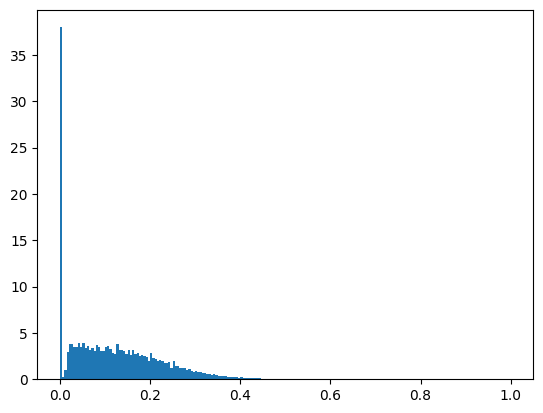

In [8]:
fig, ax = plt.subplots()
ax.hist(ds['rouge1'], bins=200, density=True)
plt.show()

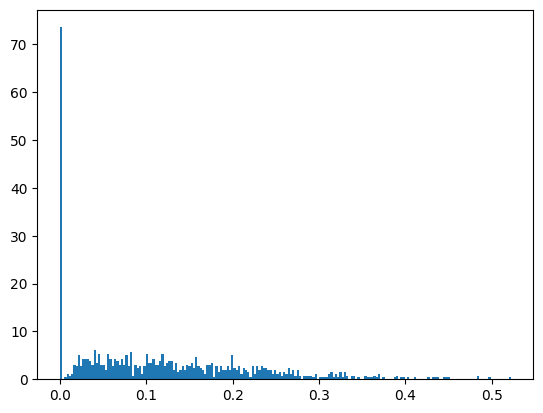

In [10]:
fig, ax = plt.subplots()
ax.hist(sub['rouge1'], bins=200, density=True)
plt.show()

In [13]:
print(sub[0].keys())

dict_keys(['resp_id', 'model', 'template_name', 'problem_id', 'template_id', 'sys_id', 'problem', 'answer', 'response', 'bertscore_precision', 'bertscore_recall', 'bertscore_f1', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'])


In [22]:
print(zero_ds[0]['answer'])
print(set(zero_ds['']))

'France seem to kick away a lot of ball, yet they have players like have Yoann Huget and Wesley Fofana in their backline.'
{'"trade-offs"', '"Wonderkid".', '"Eight."', 'ked but \nCorrected response:\n went', 'The missing blank is (b) 31-year-old.', 'with.', 'The correct answer is: players', 'Arthur Morris.', 'Europa League play-offs', 'The blank represented by "]ethibaut Courtois"', 'The blank represents Marchol Haas', "2. Derby played to end 2-2-1-0 with of Andy Carroll having mildly stirred fans' curiosity regarding a Burnel's goal offside decision condemnation.", 'no answer', 'Rat', 'He nailed his former club again when he nutmegged Daniel Sturridge', 'Deplor', '...via cost', "It'll be Fairground", "'OLLOWING '27, STEP'", 'Mikel Arteta has stepped up his injury rehabilitation.', '#shame', 'Chuck Wielgus', ' keeper', 'Until further notice.', 'damages', "Sport'sique \xa0.", 'Redemption', 'De Jong is 26 years old.', 'Bayern Munich defender Medhi Benatia (right) suffered a muscle injury

In [25]:
sub.to_csv('scores_1000.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3598667